# Introduction

This notebook trains a linear discriminant analysis model on preprocessed EEG data to predict behavioral data from neural features.

An example of this can be found in the paper, "Human stereoEEG recordings reveal network dynamics of decision-making in a rule-switching task" by Wal et al.

Behavioral data and preprocessed neural data from Subjecs in the NCSL EFRI dataset will be used in this notebook.

# Setup

## Imports

In [1]:
import h5py 
import mat73
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## Load File Paths

In [100]:
# ncsl_share = '/run/user/1000/gvfs/smb-share:server=10.162.37.21,share=main'
# data_path = f'Data/Subject06_snapshot_normalized.npy'
subs = ['16']
file_paths = {}

for sub in subs:
    # create a dictionary holding the file paths
    ncsl_share = '/mnt/ncsl_share'
    file_paths[sub] = {
        'setup_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Setup.mat',
        'raw_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Raw.mat',
        'data_path': ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/Subject{sub}_snapshot_normalized.npy', # movement onset as event
        # 'data_path' : ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/show-card_pre-2sec_post-4sec/Subject{sub}_snapshot_normalized.npy', # visual cue as event
        'out_path_metrics': f'Metrics/LeftMiddleTemporalGyrus/PredictCard/RandomForestMovementOnset/Subject{sub}',
        'out_path_plots': f'Plots/LeftMiddleTemporalGyrus/PredictCard/RandomForestMovementOnset/Subject{sub}'
    }

    raw_file = h5py.File(file_paths[sub]['raw_path'])
    setup_data = mat73.loadmat(file_paths[sub]['setup_path'])

    out_path_plots = file_paths[sub]['out_path_plots']
    out_path_metrics = file_paths[sub]['out_path_metrics']

In [68]:
setup_data.keys()

dict_keys(['elec_area', 'elec_ind', 'elec_name', 'filters', 'trial_times', 'trial_words'])

## Instantiate variables

In [101]:
elec_areas = np.array(setup_data['elec_area'])
elec_names = np.array(setup_data['elec_name'])

In [102]:
bets = setup_data['filters']['bets']

good_trials = np.where(np.isnan(bets) == False)[0] # extract indices of trials without the 'nan'

bets = bets[good_trials] # get the bet values for the good trials
subject_cards = setup_data['filters']['card1'][good_trials] # get the subject's card values for the good trials

In [6]:
# Trying to predict card value from neural data

card_categories = []
trials_to_keep = []

for i, card in enumerate(subject_cards):
    if card  < 8:
        card_categories.append(0)
        trials_to_keep.append(i)
    else:
        card_categories.append(1)
        trials_to_keep.append(i)

data = np.load(file_paths[sub]['data_path'])[:,:,:,40:60] # 40:100 is the time window of interest for visual cue as event
card_categories = np.asarray(card_categories)

In [104]:
# Trying to predict bet behavior from neural data

channel_idxs = np.where(elec_areas == 'middle temporal gyrus L')[0]

data = np.load(file_paths[sub]['data_path'])[:, channel_idxs,:,:60] # 0:60 is the time window of interest for movement onset as event
y = np.asarray([(0 if bet == 5 else 1) for bet in bets]) # 0 = low bet ($5), 1 = high bet ($20)

In [9]:
card_categories = card_categories[trials_to_keep]
y = y[trials_to_keep]

In [26]:
six_card_trials = np.where(subject_cards == 6)

(array([  4,   5,   6,   7,   8,  20,  39,  42,  44,  49,  53,  58,  59,
         64,  66,  67,  72,  76,  78,  79,  86,  89,  91,  98, 105, 108,
        114, 115, 122, 133, 135, 144, 146, 147, 155, 157, 158, 161, 167,
        172, 176, 177]),)

In [24]:
(card_categories == y).sum() / len(y)

0.9567567567567568

## Matplotlib Settings

In [105]:
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 18

## Create Frequency Bands

In [106]:
wavelet_freqs = np.logspace(np.log2(2),np.log2(150),num=63,base=2)

frequency_band_indices ={
    "Delta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 0.5 and freq < 4],
    "Theta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 4 and freq < 8],
    "Alpha" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 8 and freq < 14],
    "Beta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 14 and freq < 30],
    "Gamma" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 30]
}

In [107]:
f_band_data = np.zeros((data.shape[0], data.shape[1], 5, data.shape[3]))

for i, key in enumerate(frequency_band_indices):
    f_band_data[:,:,i,:] = data[:,:,frequency_band_indices[key],:].mean(2)

# Model Training

In [108]:
from logistic_regression import LogisticRegressionOptimal
from trees_forests import RandomForestOptimal

clf = RandomForestOptimal(data=f_band_data, setup_data=setup_data)

In [109]:
filtered_num_channels = clf.filter_channels()[2]

In [110]:
clf.train_on_opatimal_time_windows(f_band_data, y, n_processes=data.shape[1], n_channels=data.shape[1])

Channel 1 done
Channel 0 done
Channel 2 done
Channel 3 done


In [111]:
clf._elec_areas = elec_areas[channel_idxs]
clf._elec_names = elec_names[channel_idxs]

In [23]:
mtg_ch_names = elec_names[channel_idxs]

In [31]:
ch_names = []
optimal_time_windows_start = []
optimal_time_windows_end = []
accuracies = []

for optimal_time_window_info in clf._optimal_time_windows_per_channel:
    ch_idx = optimal_time_window_info[0]
    ch_names.append(clf._elec_names[ch_idx])
    optimal_time_windows_start.append(optimal_time_window_info[1][0])
    optimal_time_windows_end.append(optimal_time_window_info[1][1])
    accuracies.append(optimal_time_window_info[2])

In [32]:
import csv

info = zip(ch_names, optimal_time_windows_start, optimal_time_windows_end, accuracies)
with open('output.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Channel Names', 'Optimal Time Windows Start', 'Optimal Time Windows End', 'Accuracy'])  # Write header
    writer.writerows(info)  # Write data rows

In [112]:
peak_accuracy, optimal_channel_combination = clf.get_optimal_channel_combination(y, n_channels=data.shape[1])

In [113]:
for optimal_time_windo_info in clf._optimal_time_windows_per_channel:
    print(optimal_time_windo_info)

[1, [18, 21], 0.6893939393939394]
[2, [19, 35], 0.6212121212121212]
[3, [38, 46], 0.6212121212121212]
[0, [8, 11], 0.6136363636363636]


In [79]:
optimal_channel_combination

[8, 7, 5, 6, 4, 0, 1, 9]

[1, 9, 0, 4, 8, 6, 5, 7]


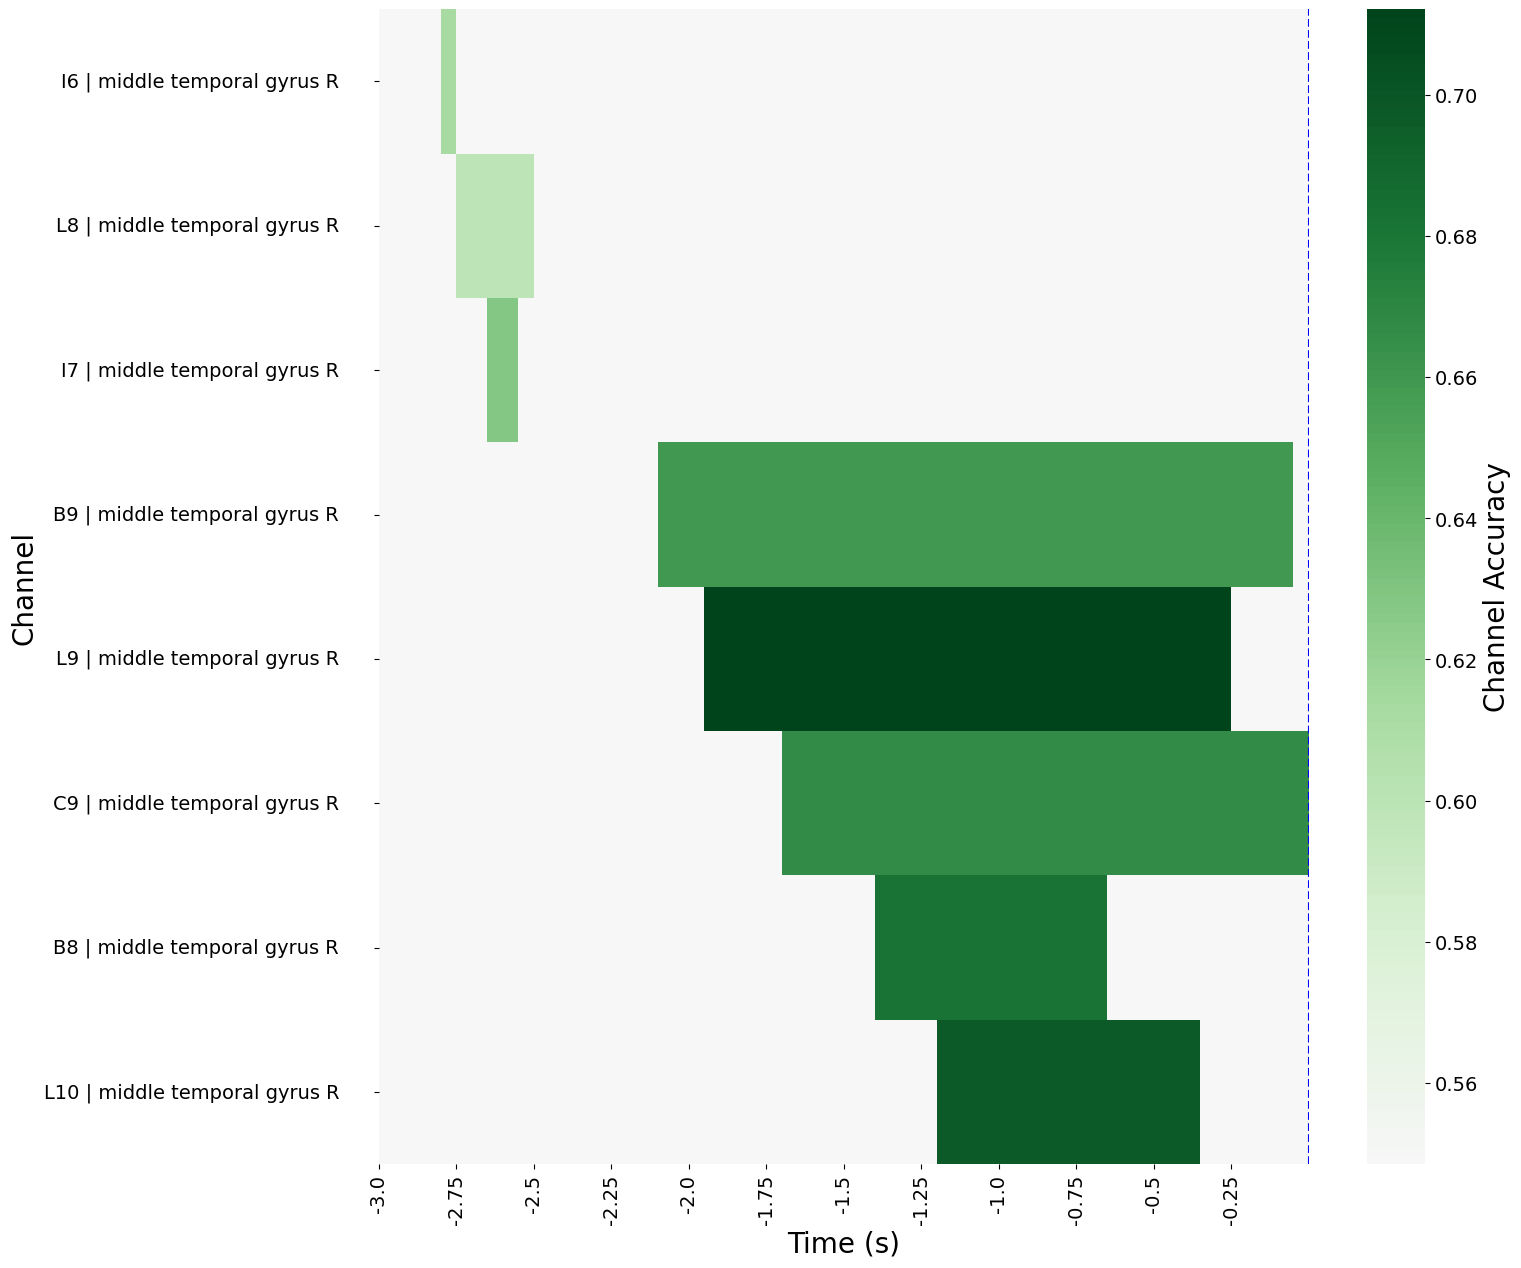

In [81]:
clf.plot_heatmap(optimal_channel_combination, 3, sub, peak_accuracy, True)

In [ ]:
optimal_accuracy = 0
optimal_combinations = []
optimal_combination = []

for combination in optimal_channels:
    # Gets all combinations of the same peak accuracy
    if combination[1] >= optimal_accuracy:
        optimal_accuracy = combination[1] 
        optimal_combinations.append(combination[0])
    else:
        break

for combination in optimal_combinations:
    # Gets the combination with the most channels
    if len(combination) > len(optimal_combination):
        optimal_combination = combination

chs = []

for optimal_info in optimal_combination:
    chs.append(optimal_info[0])

In [ ]:
clf.plot_freq_box_plots(y, chs, out_path_plots)

# Figure

In [30]:
import pandas as pd
import glob
import re

# Specify the file path pattern
# brain_hemisphere = ['Right', 'Left']

# for hemi in brain_hemisphere:
#     file_path_pattern = f'Metrics/{hemi}MiddleTemporalGyrus/PredictBet/RandomForestMovementOnset/ChannelInfo/*.csv'

# Create an empty list to store the dataframes
dfs = []

brain_region = 'RightMiddleTemporalGyrus'
prediction_variable = 'PredictBet'
event = 'ShowCard'

file_path_pattern = f'Metrics/{brain_region}/{prediction_variable}/RandomForest{event}/ChannelInfo/*.csv'

# Get a list of file paths matching the pattern
file_paths = glob.glob(file_path_pattern)

# Iterate over the file paths
for file_path in file_paths:
    match = re.search(r"Subject(\d+)", file_path)

    if match:
        number = match.group(1)
        print(number)
    else:
        print("Number not found.")

    # Read each CSV file into a dataframe
    df = pd.read_csv(file_path)
    df = df.sort_values('Optimal Time Windows Start', ascending=True)
    df['Subject'] = number

    # if hemi == 'Right':
    #     df['Brain Area'] = 'RightMTG'
    # else:
    #     df['Brain Area'] = 'LeftMTG'

    # Append the dataframe to the list
    dfs.append(df.reset_index(drop=True))

# Concatenate the dataframes into a single dataframe
concatenated_df = pd.concat(dfs)

    # Print the concatenated dataframe
    # print(concatenated_df)

15
07
12
10
16


In [3]:
concatenated_df

,Channel Names,Optimal Time Windows Start,Optimal Time Windows End,Accuracy,Subject
0,C'8,0,2,0.662791,13
1,B'8,5,22,0.633721,13
2,C'9,6,14,0.651163,13
3,F'9,7,14,0.645349,13
4,F'7,8,22,0.680233,13
5,B'6,8,22,0.656977,13
6,C'7,9,33,0.645349,13
7,F'6,27,34,0.674419,13
8,C'6,43,43,0.662791,13
9,F'8,44,51,0.651163,13


In [31]:
concatenated_df_sorted = concatenated_df.sort_values(by=['Subject', 'Optimal Time Windows Start'])

In [5]:
concatenated_df_sorted

,Channel Names,Optimal Time Windows Start,Optimal Time Windows End,Accuracy,Subject
0,I'9,0,18,0.670270,06
1,I'8,3,11,0.664865,06
2,B'9,6,10,0.648649,06
3,I'7,7,15,0.659459,06
4,C'10,7,30,0.654054,06
5,C'9,7,27,0.648649,06
6,B'10,10,12,0.675676,06
7,B'8,15,53,0.675676,06
8,C'8,32,59,0.654054,06
0,C'8,0,2,0.662791,13


In [32]:
accuracies = concatenated_df_sorted['Accuracy'].to_numpy()

In [33]:
heatmap_array = np.zeros((concatenated_df_sorted.shape[0], 60))

i = 0
y_labels = []
y_labels_colors = []

# colors = {
#     "07" : "",
#     "10" : "",
#     "12" : "",
#     "15" : "",
#     "16" : ""
# }

time = np.arange(60)/20 - 0 # 20 is the number of timesteps per second

for idx, row in concatenated_df_sorted.iterrows():
    start = row['Optimal Time Windows Start']
    end = row['Optimal Time Windows End']

    y_labels.append(f"P{row['Subject']} Ch{idx + 1}")

    if start == end:
        end += 1

    heatmap_array[i,start:end] = row['Accuracy']
    i += 1

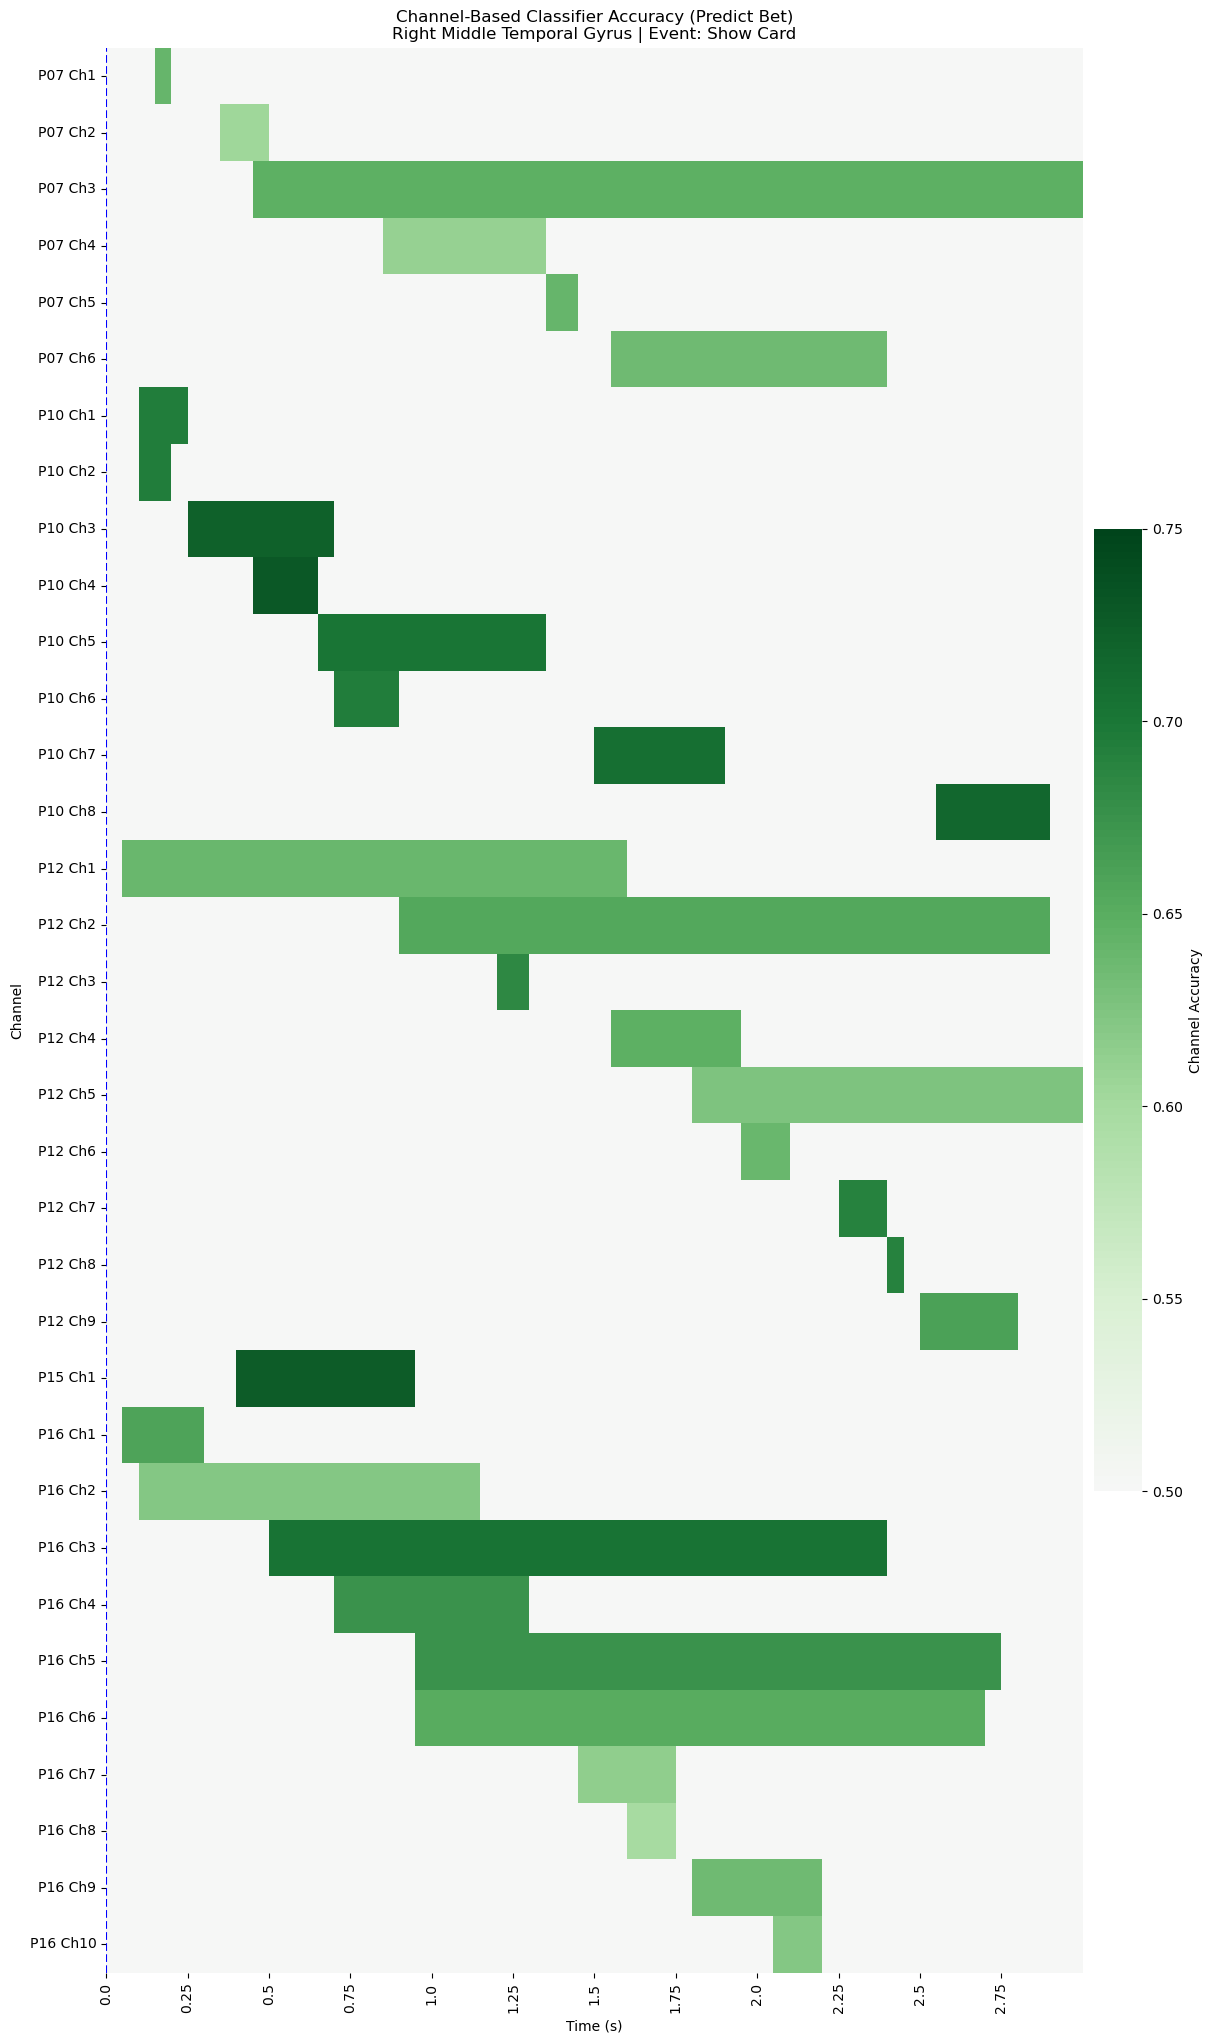

In [34]:
fig, axs = plt.subplots(1, 1, figsize=(15, 25))
sns.heatmap(heatmap_array, ax=axs, cmap='PRGn', vmin=.5, vmax=.75, center=.5, cbar_kws={"label":"Channel Accuracy", "shrink": .5, "pad": 0.01})

axs.set_ylabel('Channel')
axs.set_xlabel('Time (s)')
axs.set_title('Channel-Based Classifier Accuracy (Predict Bet)\nRight Middle Temporal Gyrus | Event: Show Card')

axs.set_xticks(np.arange(0, 60, 5))
axs.set_xticklabels(time[::5], rotation = 90)
axs.set_yticks(np.arange(concatenated_df_sorted.shape[0])+0.5)
axs.set_yticklabels(y_labels, rotation = 0)
axs.axvline(0, color = 'blue', alpha=1, ls = '--')

plot_save_path = f'Plots/{brain_region}/{prediction_variable}/RandomForest{event}/{brain_region}OptimalChannelCombination.png'
plt.savefig(plot_save_path)

plt.show()

## Extraneous Code

In [ ]:
def _convert_timesteps_to_time(event_delay, time_resolution, timesteps:np.ndarray):
    """Convert timesteps into seconds while specifying timepoint 0."""
    # time point "0 seconds" denoted by event_delay
    times = timesteps/(20/time_resolution) - event_delay 
    times = [round(time, 1) for time in times]
    return times

In [ ]:
elec_areas[channel_idxs]

'middle temporal gyrus L'

In [ ]:
elec_names[channel_idxs]

array(["B'10", "B'9", "B'8", "C'10", "C'9", "C'8", "I'9", "I'8", "I'7"],
      dtype='<U4')

In [ ]:
i = 3
ch_data = f_band_data[0,i,:,:]
ch_name = elec_names[channel_idxs][i]
ch_area = elec_areas[channel_idxs][i]

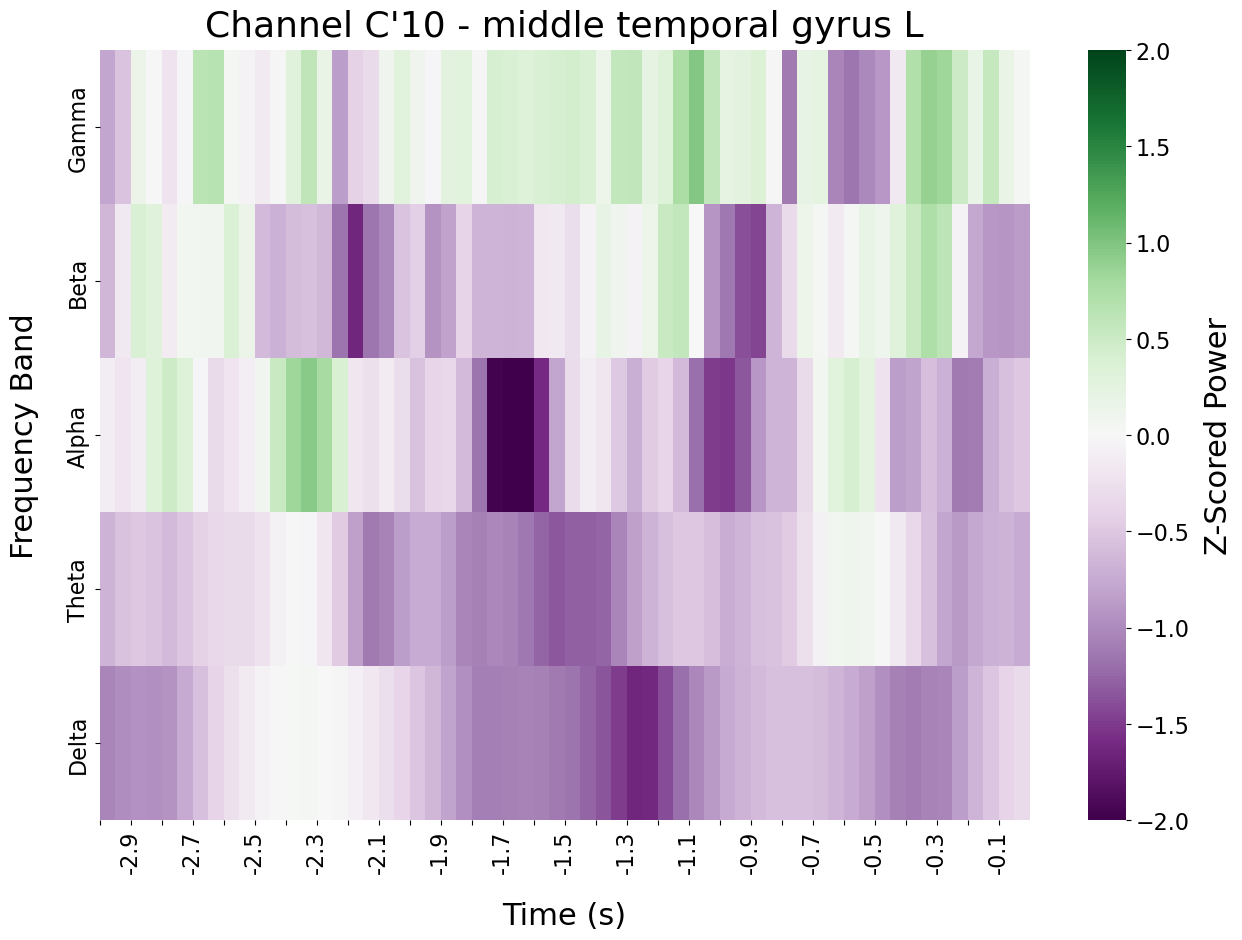

In [ ]:
f_band_labels=['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

xticks = np.arange(0, ch_data.shape[1], 2)

fig, axs = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(ch_data, cmap='PRGn', vmin = -2, vmax = 2, ax=axs, cbar_kws={"label": "Z-Scored Power"})
axs.set_yticklabels(f_band_labels)

# Hide every other xtick label
axs.set_xticks(xticks)
axs.set_xticklabels(labels=_convert_timesteps_to_time(3, 1, xticks), rotation=90)
for label in axs.get_xticklabels()[::2]:
    label.set_visible(False)

plt.gca().invert_yaxis()

axs.set_title(f'Channel {ch_name} - {ch_area}', pad=10)

# Get the colorbar object
cbar = axs.collections[0].colorbar

# Set padding for the colorbar label
cbar.set_label('Z-Scored Power', labelpad=10)

axs.set_ylabel('Frequency Band', labelpad=20)
axs.set_xlabel('Time (s)', labelpad=20)
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Create logistic regression model
model = LogisticRegression()

# Perform cross-validation
scores = cross_val_score(model, card_categories.reshape(-1, 1), y, cv=5)

# Print the accuracy scores
print("Accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

NameError: name 'card_categories' is not defined